In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from bs4 import BeautifulSoup
from bs4.dammit import EncodingDetector
import requests
import re
from fake_useragent import UserAgent
import random
import time
import pytz

# Function to get proxies so we can rotate through them
def scrape_proxies():
    proxies = []
    headers = {'User-Agent': UserAgent().random}
    resp = requests.get('https://www.sslproxies.org/', headers=headers)
    site = resp.content
    soup = BeautifulSoup(site, 'html.parser')
    proxies_table = soup.find(id='proxylisttable')
    for row in proxies_table.tbody.find_all('tr'):
        proxies.append(row.find_all('td')[0].string + ':' + row.find_all('td')[1].string)
    return proxies

In [2]:
# Function to scrape the html into beautiful soup
def scrape_html(url, max_n_tries, proxies):
    num_tries = 0
    max_tries = max_n_tries
    while num_tries < max_tries: 
        current_proxy = {"http": "http://{}".format(random.choice(proxies))}
        headers = {'User-Agent': UserAgent().random}
        resp = requests.get(
            url,
            headers=headers,
            proxies=current_proxy
        )
        if resp.status_code == 200:
            site = resp.content
            soup = BeautifulSoup(site, 'html.parser')
            return soup
        else:
            num_tries += 1
            time.sleep(random.randint(1, 2))    


# Get all the href tags from the business homepage and add them to a list
resp = requests.get('https://www.cnn.com/business')
http_encoding = resp.encoding if 'charset' in resp.headers.get('content-type', '').lower() else None
html_encoding = EncodingDetector.find_declared_encoding(resp.content, is_html=True)
encoding = html_encoding or http_encoding
soup = BeautifulSoup(resp.content, from_encoding=encoding)

links = [link['href'] for link in soup.find_all('a', href=True)]

# Not all hrefs are actual article links
# Article links always start with the date
# so we'll do a regex for that
article_links = []

for link in links:
    regexp = re.compile(r'(\d+/\d+/\d+)')
    if regexp.search(link):
        article_links.append('https://www.cnn.com' + link)
        
# There are duplicate links so we'll remove those
article_links = list(set(article_links))

# There are also video links so we'll remove those too
article_links = [each for each in article_links if '/videos/' not in each]

# Scrape each link and add to lists
links, titles, body = [], [], []

for url in article_links:
    links.append(url)
    
    proxies = scrape_proxies()
    soup = scrape_html(url, 50, proxies)
    
    try:
        titles.append(soup.h1.text)
    except AttributeError:
        titles.append(np.nan)
        
    p = soup.findAll('div', {'class': 'zn-body__paragraph'})    
    p_text = []

    for each in p:
        try:
            p_text.append(each.text)
        except AttributeError:
            p_text.append(np.nan)
            
    body.append(' '.join(p_text))
    
    time.sleep(random.randint(1, 2))

# Create a df from the lists
df = pd.DataFrame({
    'url': links,
    'title': titles,
    'body': body
})

df.head()

,url,title,body
0,https://www.cnn.com/2020/11/18/tech/marissa-ma...,Former Yahoo CEO Marissa Mayer's new company l...,"Over the years, Mayer has been the subject of ..."
1,https://www.cnn.com/2020/11/17/success/honda-c...,Honda unveils its new Civic on Twitch to attra...,"The Civic, with its affordable price tag, good..."
2,https://www.cnn.com/2020/11/18/investing/arriv...,Electric bus startup Arrival rides latest craz...,Arrival said in a statement on Wednesday that ...
3,https://www.cnn.com/2020/11/18/business/diesel...,UK to ban sales of new diesel and gasoline car...,The UK government said in a statement Wednesda...
4,https://www.cnn.com/2020/11/03/business/relian...,Reliance CEO Mukesh Ambani loses billions as o...,The wealth of Asia's top billionaire fell by a...


In [3]:
df.to_csv('data.csv')

In [18]:
import pandas as pd

df = pd.read_csv('data.csv')

In [19]:

import requests
from nltk.tokenize import sent_tokenize

print(df['body'].size)
length_of_dataset=(df.size)/3
print(length_of_dataset)

27
36.0


In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
import numpy as np
import networkx as nx
from heapq import nlargest
nltk.download("stopwords")
stop_words_palak = stopwords.words('english')
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
import sys
nlp = spacy.load('en_core_web_sm')
stopwords_saif = list(STOP_WORDS)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saifkazi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
#for i in length_of_dataset:
palak=[]
saif=[]
yash=[]
for i in range(11):
    import requests
    r = requests.post(
    "https://api.deepai.org/api/summarization",
    data={
        'text':df['body'][i],
    },
    headers={'api-key': '66b8544b-6e10-45c2-9141-5b249b292b47'}
    )
    ideal= r.json()["output"].replace('.\n', '. ') 
    size=ideal.count('.')
    #======================================palak attempt==============================================================
    def read_article():
        text=df['body'][i]
        filedata=[]
        filedata.append(text)

        article = filedata[0].split(". ")
        sentences = []

        for sentence in article:
            sentences.append(sentence.replace("[^a-zA-Z]", " ").split(" "))
        #sentences.pop() 
        return sentences

    def sentence_similarity(sent1, sent2, stopwords=None):
        if stopwords is None:
            stopwords = []

        sent1 = [w.lower() for w in sent1]
        sent2 = [w.lower() for w in sent2]

        all_words = list(set(sent1 + sent2))

        vector1 = [0] * len(all_words)
        vector2 = [0] * len(all_words)

        for w in sent1:
            if w in stopwords:
                continue
            vector1[all_words.index(w)] += 1

        for w in sent2:
            if w in stopwords:
                continue
            vector2[all_words.index(w)] += 1

        return 1 - cosine_distance(vector1, vector2)

    def build_similarity_matrix(sentences, stop_words):
        similarity_matrix = np.zeros((len(sentences), len(sentences)))

        for idx1 in range(len(sentences)):
            for idx2 in range(len(sentences)):
                if idx1 == idx2:
                    continue 
                similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2], stop_words)

        return similarity_matrix


    def generate_summary(top_n=5):
       
        summarize_text = []
        sentences =  read_article()
        sentence_similarity_martix = build_similarity_matrix(sentences, stop_words_palak)
        sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_martix)
        scores = nx.pagerank(sentence_similarity_graph)

        ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)    

        for i in range(top_n):
          summarize_text.append(" ".join(ranked_sentence[i][1]))

        ans=". ".join(summarize_text)
        return ans
    
    attempt_palak=generate_summary(size)
    #=============================================Saif Attempt================================================

    
  
    
    def calc_word_frequencies(doc):
        #print(type(doc))
        word_frequencies = {}
        for word in doc:
            if word.text not in stopwords_saif and word.text not in punctuation:
                    if word.text not in word_frequencies.keys():
                        word_frequencies[word.text] = 1
                    else:
                        word_frequencies[word.text] += 1
        return word_frequencies

    def get_max_frequency(word_frequencies):
        return max(word_frequencies.values())

    def normalize_word_frequencies(word_frequencies):
        max_frequency = get_max_frequency(word_frequencies)
        for word in word_frequencies.keys():
            word_frequencies[word] = (word_frequencies[word]/max_frequency)
        return word_frequencies

    def get_sent_scores(sentence_list,word_frequencies):
        sentence_scores = {}  
        for i,sent in enumerate(sentence_list):  
            for word in sent:
                if word.text in word_frequencies.keys():
                    if sent not in sentence_scores.keys():
                        sentence_scores[sent] = [word_frequencies[word.text],i]
                    else:
                        sentence_scores[sent][0] += word_frequencies[word.text]
        return sentence_scores

    def generate_summary(sents_in_summary):
        file_data=df['body'][i]
        doc=nlp(file_data)
       # print(doc)
        word_frequencies = calc_word_frequencies(doc)
        word_frequencies = normalize_word_frequencies(word_frequencies)
        sentence_scores = get_sent_scores([sent for sent in doc.sents],word_frequencies)

        #sorting according to decreasing order of importance and choosing the first (sents_in_summary) sentences
        summarized_sentences = sorted(sentence_scores.items(),key=lambda x: x[1],reverse=True)[:sents_in_summary]

        #sorting according to appearance of sentences in the original text
        summarized_sentences = sorted(summarized_sentences,key=lambda x: x[1][1])

        final_sentences = [x[0].text.capitalize() for x in summarized_sentences]
        summary = " ".join(final_sentences)
        return summary

    attempt_saif=generate_summary(size)
    
    count_saif=0
    count_palak=0
    i_attempt_palak = sent_tokenize(attempt_palak)
    i_attempt_saif = sent_tokenize(attempt_saif)
    #i_attempt_yash = sent_tokenize(attempt_yash)
    i_ideal = sent_tokenize(ideal)
    final_ideal=[]
    final_palak=[]
    final_saif=[]
    for sent in i_ideal:
        sent=sent.lower()
        if '.' not in sent:
            sent=sent+'. '
        final_ideal.append(sent)
    for sent in i_attempt_saif:
        sent=sent.lower()
        if '.' not in sent:
            sent=sent+'. '
        final_saif.append(sent)
    for sent in i_attempt_palak:
        sent=sent.lower()
        if '.' not in sent:
            sent=sent+'. '
        final_palak.append(sent)
    
    print(final_ideal)
    print("This was ideal summary ===============")
    print(final_palak)
    print("This was palak's summary ==============")
    print(final_saif)
    print("This was saif's summary ==============")
    for x in final_ideal:
      if x in final_palak:
       count_palak+=1

    for x in final_ideal:
      if x in final_saif:
       count_saif+=1

    palak.append((count_palak/size)*100)
    #yash.add((count_yash/size)*100)
    saif.append((count_saif/size)*100)   

["the civic, with its affordable price tag, good fuel economy and excellent safety ratings, has been the best-selling passenger car in america for the past four years, excluding corporate fleet sales, and it's on track to be the best seller again this year, according to kelley blue book.", "that's why honda's best-selling model overall in the us is the compact sport utility vehicle, the cr-v, not the civic.", 'executives also said the new civic will be more powerful and more fuel-efficient than the current model.', 'the company has offered hybrid versions in years past as well, though for the previous generation honda moved the hybrid model that used the basic civic design to its own nameplate, insight.']
This was ideal summary ===============
['executives also said the new civic will be more powerful and more fuel-efficient than the current model.', 'but the civic is important for honda because it attracts young, value-focused buyers (prices for the current civic start at just over $2

[50.0, 50.0, 75.0, 50.0, 45.0, 83.33333333333334, 25.0, 50.0, 33.33333333333333, 50.0, 33.33333333333333]
[25.0, 0.0, 33.33333333333333, 0.0, 40.0, 16.666666666666664, 25.0, 75.0, 33.33333333333333, 20.0, 33.33333333333333]


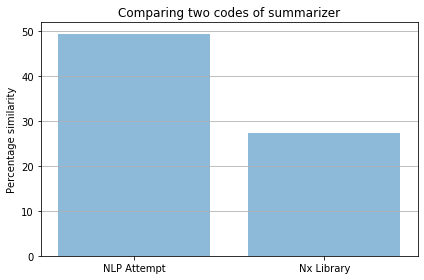

In [40]:
print(saif)
print(palak)
import numpy as np
import matplotlib.pyplot as plt
# if using a Jupyter notebook, include:
%matplotlib inline

saif_mean = np.mean(saif)
palak_mean = np.mean(palak)

materials = ['NLP Attempt', 'Nx Library']
x_pos = np.arange(len(materials))
CTEs = [saif_mean, palak_mean]

fig, ax = plt.subplots()

ax.bar(x_pos, CTEs, align='center', alpha=0.5)
ax.set_ylabel('Percentage similarity')
ax.set_xticks(x_pos)
ax.set_xticklabels(materials)
ax.set_title('Comparing two codes of summarizer')
ax.yaxis.grid(True)


# Save the figure and show
plt.tight_layout()
plt.savefig('bar_plot.png')
plt.show()




In [7]:
# Run from here directly after installing requirements.txt

import nltk
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
import numpy as np
import networkx as nx
from heapq import nlargest
nltk.download("stopwords")
stop_words_palak = stopwords.words('english')
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
import sys
nlp = spacy.load('en_core_web_sm')
stopwords_saif = list(STOP_WORDS)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saifkazi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
def read_article(text):
        filedata=[]
        filedata.append(text)

        article = filedata[0].split(". ")
        sentences = []

        for sentence in article:
            sentences.append(sentence.replace("[^a-zA-Z]", " ").split(" "))
        #sentences.pop() 
        return sentences

def sentence_similarity(sent1, sent2, stopwords=None):
    if stopwords is None:
        stopwords = []

    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]

    all_words = list(set(sent1 + sent2))

    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)

    for w in sent1:
        if w in stopwords:
            continue
        vector1[all_words.index(w)] += 1

    for w in sent2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1

    return 1 - cosine_distance(vector1, vector2)

def build_similarity_matrix(sentences, stop_words):
    similarity_matrix = np.zeros((len(sentences), len(sentences)))

    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if idx1 == idx2:
                continue 
            similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2], stop_words)

    return similarity_matrix


def generate_summary_palak(article,top_n=5):

    summarize_text = []
    sentences =  read_article(article)
    sentence_similarity_martix = build_similarity_matrix(sentences, stop_words_palak)
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_martix)
    scores = nx.pagerank(sentence_similarity_graph)

    ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)    

    for i in range(top_n):
      summarize_text.append(" ".join(ranked_sentence[i][1]))

    ans=". ".join(summarize_text)
    return ans


#=============================================Saif Attempt================================================




def calc_word_frequencies(doc):
    #print(type(doc))
    word_frequencies = {}
    for word in doc:
        if word.text not in stopwords_saif and word.text not in punctuation:
                if word.text not in word_frequencies.keys():
                    word_frequencies[word.text] = 1
                else:
                    word_frequencies[word.text] += 1
    return word_frequencies

def get_max_frequency(word_frequencies):
    return max(word_frequencies.values())

def normalize_word_frequencies(word_frequencies):
    max_frequency = get_max_frequency(word_frequencies)
    for word in word_frequencies.keys():
        word_frequencies[word] = (word_frequencies[word]/max_frequency)
    return word_frequencies

def get_sent_scores(sentence_list,word_frequencies):
    sentence_scores = {}  
    for i,sent in enumerate(sentence_list):  
        for word in sent:
            if word.text in word_frequencies.keys():
                if sent not in sentence_scores.keys():
                    sentence_scores[sent] = [word_frequencies[word.text],i]
                else:
                    sentence_scores[sent][0] += word_frequencies[word.text]
    return sentence_scores

def generate_summary_saif(sents_in_summary,file_data):
    doc=nlp(file_data)
   # print(doc)
    word_frequencies = calc_word_frequencies(doc)
    word_frequencies = normalize_word_frequencies(word_frequencies)
    sentence_scores = get_sent_scores([sent for sent in doc.sents],word_frequencies)

    #sorting according to decreasing order of importance and choosing the first (sents_in_summary) sentences
    summarized_sentences = sorted(sentence_scores.items(),key=lambda x: x[1],reverse=True)[:sents_in_summary]

    #sorting according to appearance of sentences in the original text
    summarized_sentences = sorted(summarized_sentences,key=lambda x: x[1][1])

    final_sentences = [x[0].text.capitalize() for x in summarized_sentences]
    summary = " ".join(final_sentences)
    return summary



In [10]:
size = 10
palak=[]
saif=[]
from summarizer import Summarizer
model = Summarizer()

In [12]:
for article in df['body']:
    
    attempt_palak=generate_summary_palak(article,size)
    attempt_saif=generate_summary_saif(size,article)
    result = model(article, num_sentences=size)
    ideal = "".join(result)
    
    count_saif=0
    count_palak=0
    
    i_attempt_palak = sent_tokenize(attempt_palak)
    i_attempt_saif = sent_tokenize(attempt_saif)
    i_ideal = sent_tokenize(ideal)
    final_ideal=[]
    final_palak=[]
    final_saif=[]
    for sent in i_ideal:
        sent=sent.lower()
        if '.' not in sent:
            sent=sent+'. '
        final_ideal.append(sent)
    for sent in i_attempt_saif:
        sent=sent.lower()
        if '.' not in sent:
            sent=sent+'. '
        final_saif.append(sent)
    for sent in i_attempt_palak:
        sent=sent.lower()
        if '.' not in sent:
            sent=sent+'. '
        final_palak.append(sent)

    for x in final_ideal:
      if x in final_palak:
       count_palak+=1

    for x in final_ideal:
      if x in final_saif:
       count_saif+=1

    palak.append((count_palak/size)*100)
    #yash.add((count_yash/size)*100)
    saif.append((count_saif/size)*100) 

In [15]:
import numpy as np
import matplotlib.pyplot as plt
# if using a Jupyter notebook, include:
%matplotlib inline

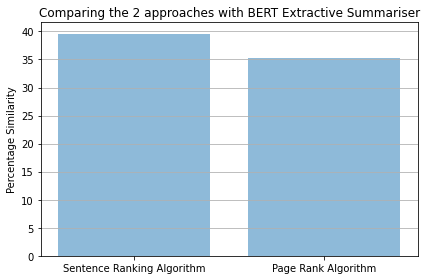

In [17]:
sentence_ranking_mean = np.mean(saif)
page_rank_mean = np.mean(palak)

labels = ['Sentence Ranking Algorithm', 'Page Rank Algorithm']
x_pos = np.arange(len(labels))
CTEs = [sentence_ranking_mean, page_rank_mean]

fig, ax = plt.subplots()

ax.bar(x_pos, CTEs, align='center', alpha=0.5)
ax.set_ylabel('Percentage Similarity')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Comparing the 2 approaches with BERT Extractive Summariser')
ax.yaxis.grid(True)


# Save the figure and show
plt.tight_layout()
plt.savefig('bar_plot.png')
plt.show()